In [1]:
from importlib import reload
import parkersolarwind as psw
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from functools import partial

### 1) Isothermal Parker Solar Wind

First, we solve and plot isothermal Parker solar wind solutions where the only free parameter is $T_0$, the coronal temperature, which is constant with radius out to infinity. This was the solution presented in the landmark Parker ([1958](https://ui.adsabs.harvard.edu/abs/1958ApJ...128..664P/abstract)) paper.

#### Code 

The solution is retrieved with the function :

`parkersolarwind.solve_parker_isothermal`(Rgrid, T0, [rho0], [r0]) $\rightarrow$ (Rgrid, rho_iso, u_iso, T_iso)

Where the inputs are: `Rgrid`[solar radii] is the radial grid spacing, `T0`[MK] is the isothermal temperature, `rho0`[kg/m^3] is the _mass_ density at the reference level and `r0`[solar radii] is the reference altitude itself. The last two are keywords and don't need to be supplied explicitly.

The outputs are: `Rgrid`[solar radii], `rho_iso`[kg cm^-3] is the density at all grid points, `u_iso`[km/s] is the velocity at all grid points and T_iso[MK] is the temperature at all grid points (which of course is just a horizontal line). 

All inputs and outputs are `astropy.units.Quantity` and so could be provided in different units as desired (e.g. km/s -> cm/hour etc...)

In [2]:
Rgrid = np.logspace(0,np.log10(200),200)*u.R_sun
T0_arr = np.linspace(1,5,5)*u.MK
iso_sols = [psw.solve_parker_isothermal(Rgrid,T0) for T0 in T0_arr]

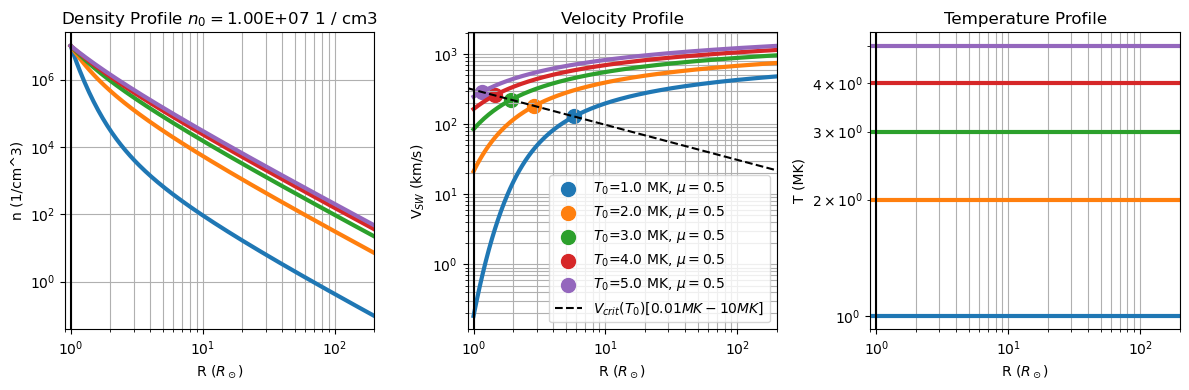

In [3]:
fig,axes=psw.plot_isothermal(iso_sols,lw=3)

### 2) Solve and plot a pure polytropic solar wind

Next, we solve for transonic solar wind solutions for the case of a polytropic fluid with $\frac{d}{dr}(p\rho^\gamma) = \frac{d}{dr} (T\rho^{\gamma-1}) = 0$, and a temperature at the coronal base $T_0$. 

This is a two step process following Shi+([2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220903508S/abstract)) III.B. In the first step, the critical point (radius and velocity) is numerically solved for. In the second step, we solve Bernouilli's equation for a spherically symmetric hydrodynamic steady flow with polytropic index $\gamma$ subject to the boundary condition that forces the solution to intersect with the critical point, _and_ be monotonically increasing. 

Below we plot solutions for a range of adiabatic indices for a fixed coronal temperature.

Note that for a given $T_0$ there is a max adiabatic index $\gamma_c$ at which the critical radius $r_c \rightarrow \infty$ and therefore transonic solutions don't exist. 

In the example below, we go up to $\gamma=1.4$ at $T_0=4MK$ which is close to the critical limit, and the max $\gamma$ which gives solutions at _any_ temperature. 

The combinations of $\gamma$ and $T_0$ do not give realistic solutions for solar wind measurements: To get $\gamma$ large enough to explain observations of the drop off in plasma temperature with distance, $T_0$ needs to be unrealistically high.

#### Code

The solution is retrieved with the function :

`parkersolarwind.solve_parker_polytropic`(Rgrid, T0, gamma, [rho0], [r0], [u0]) $\rightarrow$ (Rgrid, rho_poly, u_poly, T_poly, r_crit, uc_crit)

Where the inputs are: `Rgrid`[solar radii] is the radial grid spacing, `T0`[MK] is the temperature at the inner boundary, `rho0`[kg/cm^3] is the _mass_ density at the reference level, `r0`[solar radii] is the reference altitude. `u0`[solar radii], which defaults to `None`, can be used to provide an arbitrary flow speed at the inner boundary, bypassing the critical point solution part. If it is used then the solution will not be guaranteed to be transonic. This is however useful when combining the polytropic solution with an isothermal layer (see next section). 

The outputs are: `Rgrid`[solar radii], `rho_poly`[kg/cm^3] is the density at all grid points, `u_poly`[km/s] is the velocity at all grid points and `T_poly`[MK] is the temperature at all grid points. (`r_crit`[solar radii],`uc_crit`[km/s]) are the radius and sound speed at the critical point for a transonic solution.

All inputs (except for `type(gamma)==float`) and all outputs are `astropy.units.Quantity` and so could be provided in different units as desired (e.g. km/s -> cm/hour etc...). Note the plotting routine defined here also needs to know `T0` and `gamma`, and they must be appended as a tuple to the output of `solve_parker_polytropic`.

In [4]:
T0 = 4*u.MK
gammas = [1.05,1.1,1.2,1.3,1.4]
mu=0.5
Rgrid = np.logspace(0,np.log10(200),200)*u.R_sun
sols = [psw.solve_parker_polytropic(Rgrid, T0, gamma)
        for gamma in gammas
       ]

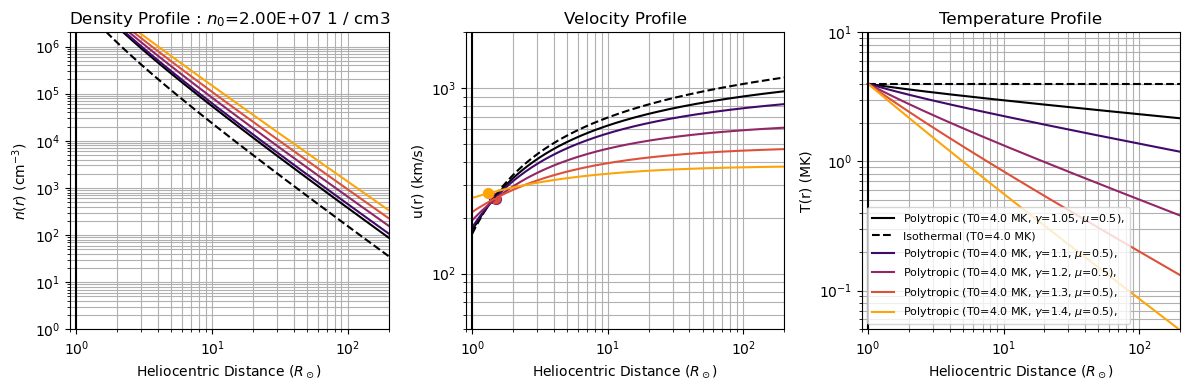

In [5]:
fig,axes=psw.plot_polytropic(
    sols,[True,False,False,False,False]
)

### 3) Solve and plot an isothermal layer model

In this example, the solar wind is assumed to be isothermal from $1R_\odot$ out to some radius $R_{iso}$, approximating temperature behavior in the corona. 

Beyond this radius the solar wind is assumed to be polytropic with index $\gamma$. 

As long as (1) the solar wind goes supersonic inside the isothermal layer and (2) the solar wind remains supersonic across the discontinuity in sound speed at the isothermal-polytropic boundary, then accelerating solutions are found for $r \rightarrow \infty$ 

#### Code

The solution is retrieved with the function :

`parkersolarwind.solve_isothermal_layer`(Rgrid, R_iso, T_iso, gamma, [rho0]) $\rightarrow$ (R_iso, rho_iso, u_iso, T_iso, R_poly, rho_poly, u_poly, T_poly)

Where the inputs are: `Rgrid`[solar radii] is the radial grid spacing, `R_iso`[solar radii] is the radius of the outer boundary of the isothermal layer, `T0`[MK] is the temperature at the inner boundary, `gamma` is the polytropic index for the polytropic layer, `rho0`[kg/cm^3] is the _mass_ density at the reference level.

The outputs are: `R_[iso/poly]`[solar radii], `rho_[iso/poly]`[kg/cm^3] is the density at all grid points, `u_[iso/poly]`[km/s] is the velocity at all grid points and `T_[iso/poly]`[MK] is the temperature at all grid points where `iso` or `poly` indicate whether the quantity is for the isothermal or polytropic layer respectively.

All inputs (except for `type(gamma)==float`) and all outputs are `astropy.units.Quantity` and so could be provided in different units as desired (e.g. km/s -> cm/hour etc...).

In [6]:
sol = psw.solve_isothermal_layer(
    np.logspace(0,np.log10(200),400)*u.R_sun, # Radial grid points
    11.5*u.R_sun, # Isothermal layer outer radius
    1.64*u.MK, # Isothermal layer temperature
    1.38, # Polytropic layer polytropic index
    n0=11e6/u.cm**3 # Density normalization
) 

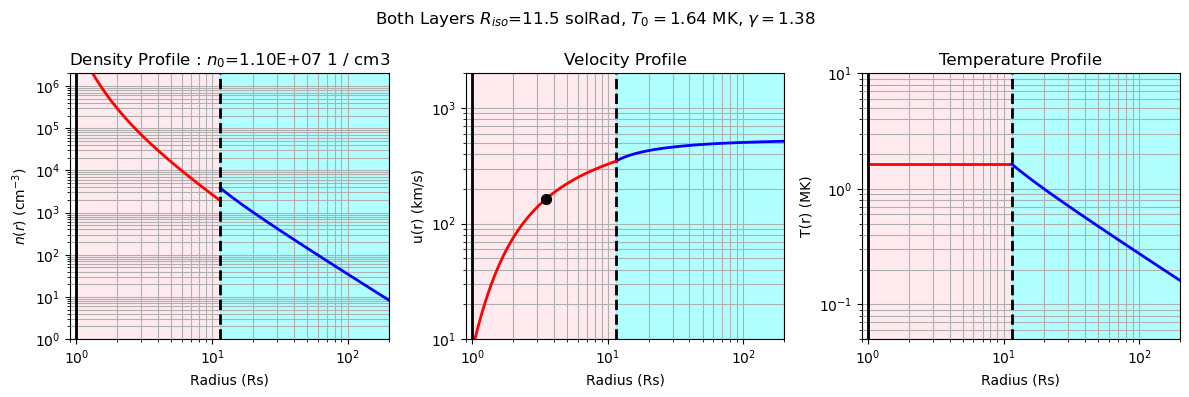

In [7]:
fig,axes=psw.plot_isothermal_layer(sol)

### 4) Including an External Force

Lastly, we follow section D of Shi+2022 in which the solutions are modified by the addition of an external force, e.g. alfven wave momentum flux. 

We introduce some functions which define the forcing as a function of radius. Here we define one which is constant with radius and one which follows the functional form posited in Shi+2022:

In [8]:
def fconst(r,mult=0.01) : 
    if len(np.array(r).shape) > 0 : return (const.G*const.M_sun/const.R_sun**2)*mult*np.ones(len(np.array(r)))
    else : return (const.G*const.M_sun/const.R_sun**2)*mult
def fshi(r,alpha=3,beta=8,mult=0.01) :
    # alpha and beta set a point at which the force is maximum
    # the function tends to f0 beta e^alpha / r^2 as r-> infinity
    f0 = mult * (const.G*const.M_sun/const.R_sun**2)
    s = r/const.R_sun
    return f0*(1+beta*(s-1))/s**3 * np.exp(alpha*(1-1/s))

For these functions we can also compute analytically their integrals, which is what will appear in the adjusted Bernouilli equation:

In [9]:
def int_fconst(r1,r2,mult=0.01): 
    return fconst(r2,mult)*(r2-r1)
def int_fshi(r1,r2, alpha=3,beta=8,mult=0.01,r0=1, 
             norm_factor=190761.0176800345):
    # r1,r2,r0 all floats with units R_sun
    f0 = mult * norm_factor # express in units of (km/s)^2
    s1 = r1/r0
    s2 = r2/r0
    term1 = ((alpha*beta*(s1-1)+(1-beta)*s1+alpha)
             /(alpha**2*s1)*np.exp(alpha*(1-1/s1)))
    term2 = ((alpha*beta*(s2-1)+(1-beta)*s2+alpha)
             /(alpha**2*s2)*np.exp(alpha*(1-1/s2)))
    return f0*(term2-term1)

Let's take a look at these functions and their integrals:

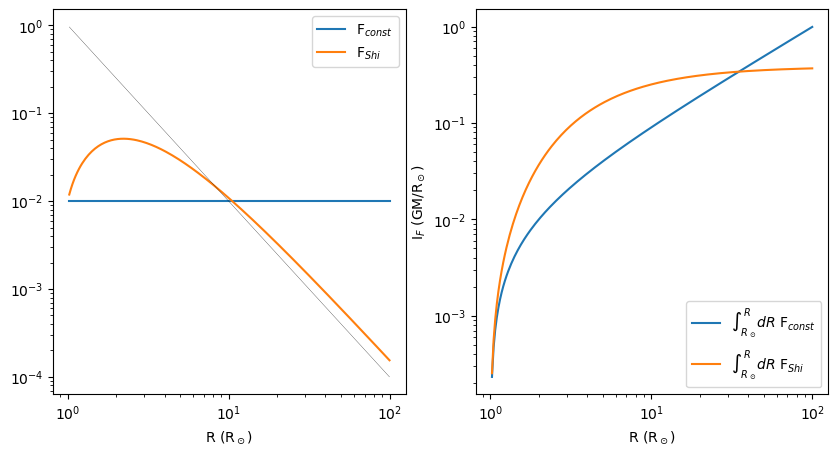

In [10]:
fig,axes=plt.subplots(figsize=(10,5),ncols=2) 
rgrid = np.logspace(0.01,2,200)*u.R_sun

norm0 = const.G*const.M_sun/const.R_sun**2
axes[0].plot(rgrid,(fconst(rgrid).to(norm0.unit)/norm0),label="F$_{const}$")
axes[0].plot(rgrid,(fshi(rgrid).to(norm0.unit)/norm0),label="F$_{Shi}$")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_xlabel("R (R$_\odot$)")
axes[1].set_ylabel("F (GM/R$_\odot$^2)")

norm1 = const.G*const.M_sun/const.R_sun
axes[1].plot(rgrid,(int_fconst(const.R_sun,rgrid).to(norm1.unit)/norm1),
             label="$\int_{R_\odot}^R dR$ F$_{const}$")
axes[1].plot(rgrid,(int_fshi(1,rgrid.value)*(u.km**2/u.s**2).to(norm1.unit)/norm1),
             label="$\int_{R_\odot}^R dR$ F$_{Shi}$")
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_xlabel("R (R$_\odot$)")
axes[1].set_ylabel("I$_F$ (GM/R$_\odot$)")

axes[0].plot(rgrid,1/rgrid.value**2,color="black",linewidth=0.2)

#### 4a) Isothermal + External Force

We first consider just the isothermal case. For an outwards directed external force, the effect is to cause the wind to accelerate faster than it would from thermal pressure alone, so it becomes supersonic closer in (the critical radius is shifted inwards while the critical speed remains the same), leading to a steeper initial acceleration and higher asymptotic wind speed.

The solution proceeds similarly to the standard isothermal case except the critical radius is now solved for numerically and the functional form of the Bernouilli equation is slightly less tidy (c.f. Shi+2022 eqn. (26) vs. eqn. (5)).

In [11]:
## Generate a series of models with monotically stronger forcing:
Rgrid = np.logspace(0,np.log10(200),200)*u.R_sun
T0 = 1.5*u.MK
sols_fext,rcrits,ucrits,fexts = [],[],[],[]
for force_mult in np.linspace(0,0.04,5) :
    sols_fext.append(
        psw.solve_parker_isothermal_fext(Rgrid[::1],T0,
                                         partial(fshi,mult=force_mult),
                                         partial(int_fshi,mult=force_mult)
                                        )
    )
    rcrits.append(psw.critical_radius_fext(partial(fshi,mult=force_mult),T_coronal=T0))
    ucrits.append(psw.critical_speed(T_coronal=T0))
    fexts.append(partial(fshi,mult=force_mult))

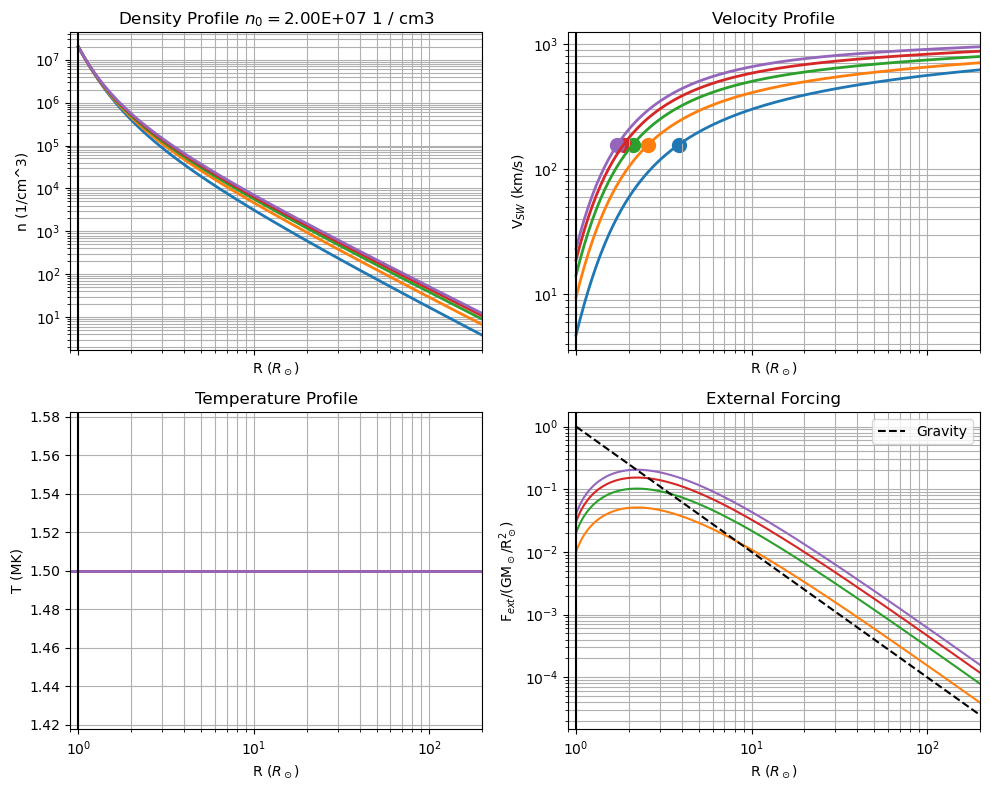

In [12]:
fig,axes = psw.plot_isothermal(sols_fext,fexts=fexts)
axes[2].set_yscale("linear")
plt.tight_layout()

#### 4b) Polytropic + External Force

Next, we repeat the polytropic solution with an external force applied.

In [13]:
from importlib import reload; reload(psw)
T0 = 2*u.MK
mu=0.5
Rgrid = np.logspace(0,np.log10(200),200)*u.R_sun
mults = [0.0,0.01,0.02]
solsf = [psw.solve_parker_polytropic_fext(Rgrid, 4*u.MK, 1.1, 
                                       partial(fshi,mult=mult), 
                                       partial(int_fshi,mult=mult),
                                      )
        for mult in mults
       ]

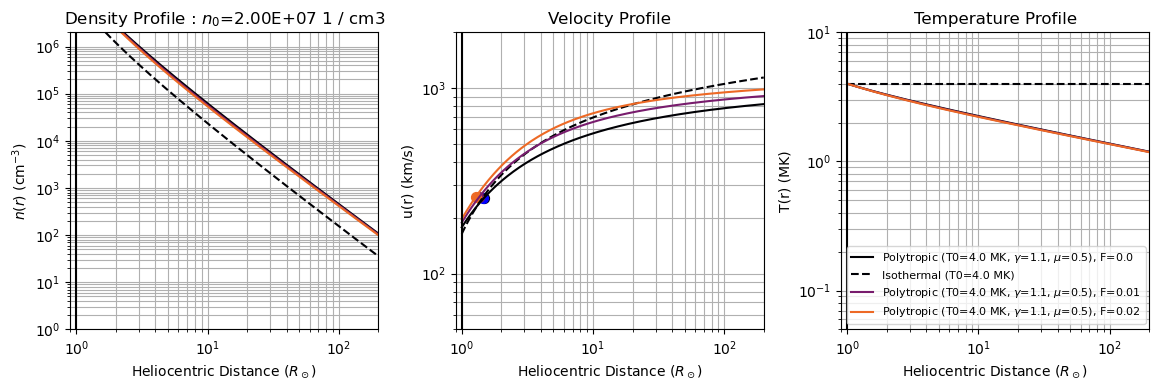

In [14]:
fig,axes=psw.plot_polytropic(
    solsf,
    [True,False,False,False,False],
    fexts=mults
)

### 4c) Finally, we repeat the isothermal layer solution with the external force (smoothly varying across the iso-poly boundary).

In [15]:
mult=0.01
fext = partial(fshi,mult=mult)
ifext = partial(int_fshi,mult=mult)
sol = psw.solve_isothermal_layer_fext(
    np.logspace(0,np.log10(200),400)*u.R_sun, # Radial grid points
    11.5*u.R_sun, # Isothermal layer outer radius
    1.64*u.MK, # Isothermal layer temperature
    1.38, # Polytropic layer polytropic index
    fext,# Force function f(r)
    ifext,# Integral of force function i_f(r0,r1)
    n0=11e6/u.cm**3 # Density normalization
) 

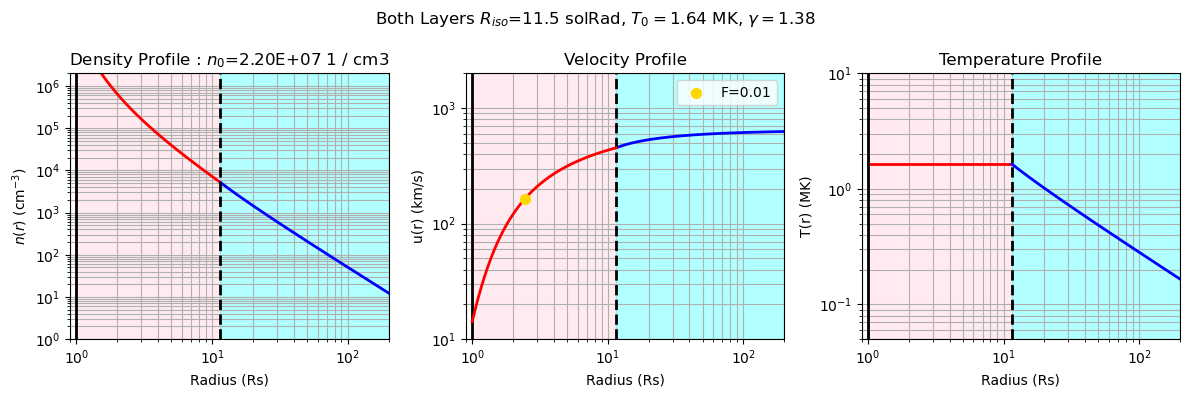

In [16]:
fig,axes=psw.plot_isothermal_layer(sol,force_details = [mult,fext,ifext])

### 5) Generalize to 2 fluid version

In this last section, we generalize the solution to allow two different polytropic indices for protons and electrons, informed by Dakeyo+2022. 

As of this commit, this is only implemented for the polytropic case where the solution starts supersonic already. Future work is needed to solve the polytropic critical point.

In [29]:
mult=0.01
fext = partial(fshi,mult=mult)
ifext = partial(int_fshi,mult=mult)
R_sol = np.logspace(0,np.log10(200),500)*u.R_sun
R_iso=11.5*u.R_sun
T0p=1.7*u.MK
T0e=0.6*T0p
gammap=1.38
gammae=gammap
gammae_diff = 1.1

psol2f_equal_indices = psw.solve_isothermal_layer_2fluid_fext(
        R_sol,R_iso,T0e,T0p,gammae,gammap,fext,ifext
    )
psol2f_different_indices = psw.solve_isothermal_layer_2fluid_fext(
        R_sol,R_iso,T0e,T0p,gammae_diff,gammap,fext,ifext
    )

(10.0, 750.0)

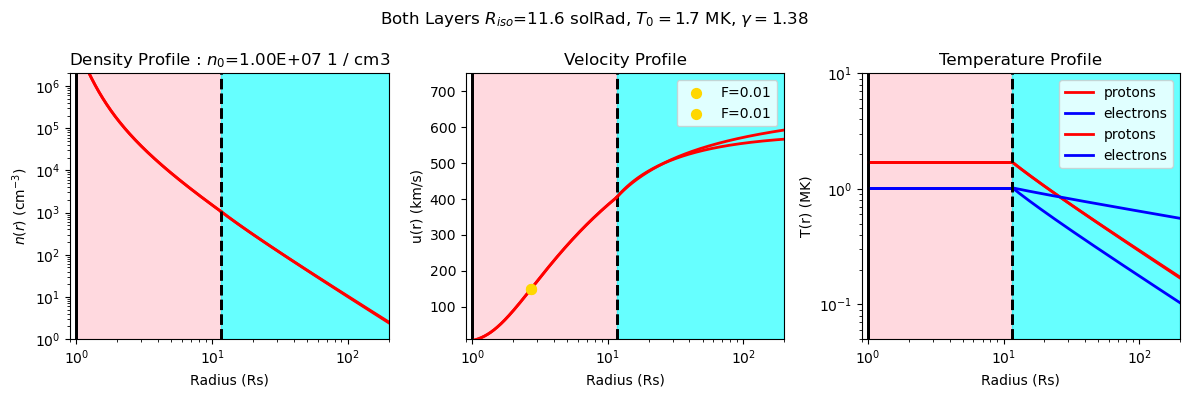

In [33]:
fig,axes=psw.plot_isothermal_layer_2fluid(psol2f_equal_indices,force_details = [mult,fext,ifext],bkg_alpha=0.6)
fig,axes=psw.plot_isothermal_layer_2fluid(psol2f_different_indices,force_details = [mult,fext,ifext],fig=fig,axes=axes,bkg_alpha=0)
axes[1].set_yscale("linear")
axes[1].set_ylim(ymax=750)